In [1]:
"""
Example demonstrating how to fit a complex H-alpha profile after subtracting off a satellite line 
(in this case, He I 6678.151704)
"""
from __future__ import print_function
import pyspeckit
from astropy import units as u

3351.0194731303422

In [13]:
z = 1
cosmology = pyspeckit.cosmology.Cosmology()
d = cosmology.LuminosityDistance(z) #* #cm_per_mpc

In [ ]:
/home/felipe/miniconda3/envs/SHEAP/lib/python3.10/site-packages/pyspeckit

'/home/felipe/miniconda3/envs/SHEAP/lib/python3.10/site-packages/pyspeckit/__init__.py'

In [2]:
sp = pyspeckit.OpticalSpectrum('sn2009ip_halpha.fits')

FileNotFoundError: [Errno 2] No such file or directory: 'sn2009ip_halpha.fits'

In [ ]:




# start by plotting a small region around the H-alpha line
# xmin=u.Quantity(6100, sp.xarr.unit)
# xmax=u.Quantity(7000, sp.xarr.unit)
# ymin=u.Quantity(0, sp.unit)
# ymax=u.Quantity(2.23, sp.unit)
sp.plotter(xmin=6100*u.AA, xmax=7000*u.AA, ymax=2.23*u.dimensionless_unscaled, ymin=0*u.dimensionless_unscaled)
# sp.plotter(xmin=xmin,xmax=xmax,ymax=ymax,ymin=ymin)

# the baseline (continuum) fit will be 2nd order, and excludes "bad"
# parts of the spectrum
# The exclusion zone was selected interatively (i.e., cursor hovering over the spectrum)
sp.baseline(xmin=6100, xmax=7000,
        exclude=[6450,6746,6815,6884,7003,7126,7506,7674,8142,8231],
        subtract=False, reset_selection=True, highlight_fitregion=True,
        order=2)

# Fit a 4-parameter voigt (figured out through a series if guess and check fits)
sp.specfit(guesses=[2.4007096541802202,  6563.2307968382256, 3.5653446153950314,  1,
                    0.53985149324131965, 6564.3460908526877, 19.443226155616617,  1,
                    0.11957267912208754, 6678.3853431367716, 4.1892742162283181,  1,
                    0.10506431180136294, 6589.9310414408683, 72.378997529374672,  1,],
                    fittype='voigt')

# Now overplot the fitted components with an offset so we can see them
# the add_baseline=True bit means that each component will be displayed with the "Continuum" added
# If this was off, the components would be displayed at y=0
# the component_yoffset is the offset to add to the continuum for plotting only (a constant)
sp.specfit.plot_components(add_baseline=True,component_yoffset=-0.2)

# Now overplot the residuals on the same graph by specifying which axis to overplot it on
# clear=False is needed to keep the original fitted plot drawn
# yoffset is the offset from y=zero
sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0.20,label=False)

# save the figure
sp.plotter.savefig("SN2009ip_UT121002_Halpha_voigt_zoom.png")

# print the fit results in table form
# This includes getting the equivalent width for each component using sp.specfit.EQW
print(" ".join(["%15s %15s" % (s,s+"err") for s in sp.specfit.parinfo.parnames])," ".join(["%15s" % ("EQW"+str(i)) for i,w in enumerate(sp.specfit.EQW(components=True))]))
print(" ".join(["%15g %15g" % (par.value,par.error) for par in sp.specfit.parinfo])," ".join(["%15g" % w for w in sp.specfit.EQW(components=True)]))

# here are some other fitted parameters that can be printed:
print("Fitted EQW:", sp.specfit.EQW())
print("Direct EQW:", sp.specfit.EQW(fitted=False))
print("Approximate FWHM:", sp.specfit.measure_approximate_fwhm())
print("Approximate FWHM (with interpolation):", sp.specfit.measure_approximate_fwhm(interpolate_factor=10))

# zoom in further for a detailed view of the profile fit
sp.plotter.axis.set_xlim(6562-150,6562+150)
sp.plotter.savefig("SN2009ip_UT121002_Halpha_voigt_zoomzoom.png")

# now we'll re-do the fit with the He I line subtracted off
# first, create a copy of the spectrum
just_halpha = sp.copy()

# Second, subtract off the model fit for the He I component
# (identify it by looking at the fitted central wavelengths)
just_halpha.data -= sp.specfit.modelcomponents[2,:]

# re-plot
just_halpha.plotter(xmin=6100,xmax=7000,ymax=2.00,ymin=-0.3)

# this time, subtract off the baseline - we're now confident that the continuum
# fit is good enough
just_halpha.baseline(xmin=6100, xmax=7000,
        exclude=[6450,6746,6815,6884,7003,7126,7506,7674,8142,8231],
        subtract=True, reset_selection=True, highlight_fitregion=True, order=2)

# Do a 3-component fit now that the Helium line is gone
# I've added some limits here because I know what parameters I expect of my fitted line
just_halpha.specfit(guesses=[2.4007096541802202, 6563.2307968382256, 3.5653446153950314, 1,
                    0.53985149324131965, 6564.3460908526877, 19.443226155616617,  1,
                    0.10506431180136294, 6589.9310414408683, 50.378997529374672,  1,],
                    fittype='voigt',
                    xmin=6100,xmax=7000,
                    limitedmax=[False,False,True,True]*3,
                    limitedmin=[True,False,True,True]*3,
                    limits=[(0,0),(0,0),(0,100),(0,100)]*3,
                   )

# overplot the components and residuals again
just_halpha.specfit.plot_components(add_baseline=False,component_yoffset=-0.1)
just_halpha.specfit.plotresiduals(axis=just_halpha.plotter.axis,clear=False,yoffset=-0.20,label=False)

# The "optimal chi^2" isn't a real statistical concept, it's something I made up
# However, I think it makes sense (but post an issue if you disagree!):
# It uses the fitted model to find all pixels that are above the noise in the spectrum
# then computes chi^2/n using only those pixels
just_halpha.specfit.annotate(chi2='optimal')

# save the figure
just_halpha.plotter.savefig("SN2009ip_UT121002_Halpha_voigt_threecomp.png")

# A new zoom-in figure
import pylab

# now hide the legend
just_halpha.specfit.fitleg.set_visible(False)
# overplot a y=0 line through the residuals (for reference)
pylab.plot([6100,7000],[-0.2,-0.2],'y--')
# zoom vertically
pylab.gca().set_ylim(-0.3,0.3)
# redraw & save
pylab.draw()
just_halpha.plotter.savefig("SN2009ip_UT121002_Halpha_voigt_threecomp_zoom.png")


# Part of the reason for doing the above work is to demonstrate that a
# 3-component fit is better than a 2-component fit
#
# So, now we do the same as above with a 2-component fit

just_halpha.plotter(xmin=6100,xmax=7000,ymax=2.00,ymin=-0.3)
just_halpha.specfit(guesses=[2.4007096541802202, 6563.2307968382256, 3.5653446153950314, 1,
                    0.53985149324131965, 6564.3460908526877, 19.443226155616617,  1],
                    fittype='voigt')
just_halpha.specfit.plot_components(add_baseline=False,component_yoffset=-0.1)
just_halpha.specfit.plotresiduals(axis=just_halpha.plotter.axis,clear=False,yoffset=-0.20,label=False)
just_halpha.specfit.annotate(chi2='optimal')
just_halpha.plotter.savefig("SN2009ip_UT121002_Halpha_voigt_twocomp.png")
just_halpha.specfit.fitleg.set_visible(False)
pylab.plot([6100,7000],[-0.2,-0.2],'y--')
pylab.gca().set_ylim(-0.3,0.3)
pylab.draw()
just_halpha.plotter.savefig("SN2009ip_UT121002_Halpha_voigt_twocomp_zoom.png")



In [1]:
import pyspeckit
import astropy.units as u
import numpy as np

# Some lines
Hbeta = 4862.721
OIIIa = 4960.295
OIIIb = 5008.239
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68

In [2]:
# Offsets between SII lines in each complex
SIIb_off = SIIb - SIIa
OIIIb_off = OIIIb - OIIIa
NIIa_off_Ha = NIIa - Halpha
NIIb_off_Ha = NIIb - Halpha
SIIa_off_Ha = SIIa - Halpha 
SIIb_off_Ha = SIIb - Halpha 

In [3]:
# Guesses
narrow = 5.
broad = 30.

In [4]:
# Initialize spectrum object
spec = pyspeckit.Spectrum('sample_sdss.txt')
spec.unit = 'erg s^{-1} cm^{-2} \\AA^{-1}'
spec.xarr.set_unit = u.dimensionless_unscaled

In [5]:
# H-alpha
spec.specfit.selectregion(xmin = Halpha - 5, xmax = Halpha + 5)
ampHa = np.max(spec.data[spec.specfit.xmin:spec.specfit.xmax])

Line   Pos   Flux (erg/s/cm^2)    FWHM (Angstrom)   Luminosity (erg/s)   Amplitude
NIIa 6551.278860558796 1.4898286339310627e-15 5.644535855161474 8.776436239690361e+39 2.47956713094345e-16
H_3-2 6566.032860558796 3.980306425770519e-15 5.644535855161474 2.3447599787386835e+40 6.624545105152182e-16
NIIb 6586.6888605587965 4.469485901793189e-15 5.644535855161474 2.6329308719071094e+40 7.43870139283035e-16
SIIa 6719.708860558796 1.3510367442713193e-15 5.644535855161474 7.958826655310981e+39 2.2485715655449167e-16
SIIb 6734.098860558796 1.2736237919223567e-15 5.644535855161474 7.502794448020021e+39 2.1197308332740525e-16
H_3-2_1 6566.032860558796 1.8202258255921742e-14 132.89566052269862 1.0722774107244515e+41 1.2867146974457242e-16
H_3-2_2 6566.032860558796 2.959173344521302e-14 59.9348691598406 1.7432203670200245e+41 4.638297860572207e-16


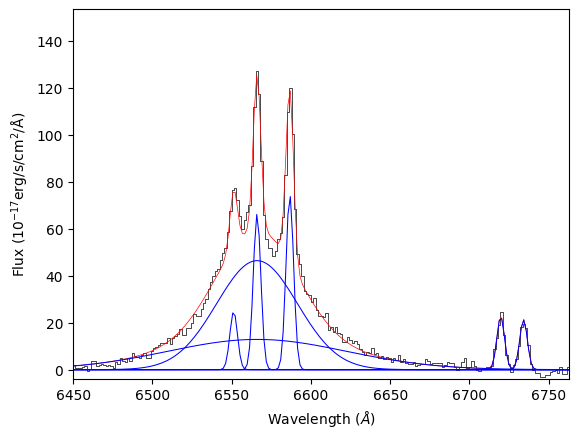

In [7]:
#from __future__ import print_function
# Test measurements class on an SDSS AGN spectrum
# H-alpha
spec.specfit.selectregion(xmin = Halpha - 5, xmax = Halpha + 5)
ampHa = np.max(spec.data[spec.specfit.xmin:spec.specfit.xmax])

# SII
spec.specfit.selectregion(xmin = SIIa - 20, xmax = SIIb + 20)
smallamp = np.max(spec.data[spec.specfit.xmin:spec.specfit.xmax])    

spec.specfit(guesses = [smallamp, SIIa, narrow, smallamp, SIIb, narrow],
        tied=['', '', 'p[-1]', '', 'p[1] + {0}'.format(SIIb_off), ''],
        negamp=False, quiet=True, multifit=None, show_components=True)
    
ampSIIa, lamSIIa, sigmaSII, ampSIIb, lamSIIb, sigmaSII = spec.specfit.modelpars

opz = lamSIIa / SIIa    # Calculate (1 + z)

# Now, use SII/OIII fit information to help fit NII-Halpha complex
spec.specfit.selectregion(xmin = NIIa - 100, xmax = NIIb + 100)

guesses = [2 * smallamp, NIIa * opz, sigmaSII, ampHa, Halpha * opz, sigmaSII,
          6 * smallamp, NIIb * opz, sigmaSII,
          ampSIIa, lamSIIa, sigmaSII, ampSIIb, lamSIIb, sigmaSII]
tied = ['', 'p[4] + {0}'.format(NIIa_off_Ha), 'p[{0}]'.format(len(guesses) - 1), 
        '', '', 'p[{0}]'.format(len(guesses) - 1), 
        '3 * p[0]', 'p[4] + {0}'.format(NIIb_off_Ha), 'p[{0}]'.format(len(guesses) - 1),
        '', 'p[4] + {0}'.format(SIIa_off_Ha), 'p[{0}]'.format(len(guesses) - 1), 
        '', 'p[4] + {0}'.format(SIIb_off_Ha), '']                                                
fixed = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

minp = []
maxp = []
lmin = []
lmax = []
for i, element in enumerate(guesses):
    minp.append(element - 0.2 * element)
    maxp.append(element + 0.2 * element)

    # Don't limit amplitude
    if i % 3 == 0:
        lmin.append(False)
        lmax.append(False)
    else:
        lmin.append(True)
        lmax.append(True)
        
# Plot, and do final fit
spec.plotter(xmin = NIIa - 100, xmax = SIIb + 30)

spec.specfit(guesses=guesses, tied=tied, fixed=fixed, negamp=False,
        limitedmin=lmin, limitedmax=lmax, minpars=minp, maxpars=maxp,
        show_components=True)
    
guesses.extend([50, Halpha * opz, 50])
tied.extend(['', 'p[4]', ''])
fixed.extend([0, 0, 0]) 

lmin.extend([True, False, False])
lmax.extend([False, False, False])
minp.extend([0, 0, 0]) 
maxp.extend([0, 0, 0]) 

spec.specfit(guesses = guesses, tied = tied, fixed = fixed, negamp = False,
    limitedmin = lmin, limitedmax = lmax, minpars = minp, maxpars = maxp)

guesses.extend([10, Halpha * opz, 25])
tied.extend(['', 'p[4]', ''])
fixed.extend([0, 0, 0])   

lmin.extend([True, False, False])
lmax.extend([False, False, False])
minp.extend([0, 0, 0]) 
maxp.extend([0, 0, 0])                                 

spec.plotter(xmin=NIIa - 100, xmax=SIIb + 30)

spec.specfit(guesses=guesses, tied=tied, fixed=fixed, negamp=False,
    limitedmin=lmin, limitedmax=lmax, minpars=minp, maxpars=maxp, annotate=False,
    show_components=True)
    
spec.plotter.refresh()

spec.measure(z = 0.05, fluxnorm = 1e-17)

# Overplot positions of lines and annotate
# y = spec.plotter.ymax * 0.85
# for i, line in enumerate(spec.measurements.lines.keys()):
#     x = spec.measurements.lines[line]['modelpars'][1]
#     spec.plotter.axis.plot([x]*2, [spec.plotter.ymin.value, spec.plotter.ymax.value], ls = '--', color = 'k')
#     try: spec.plotter.axis.annotate(spec.speclines.optical.lines[line][-1], 
#         (x, y), rotation = 90, ha = 'right', va = 'center')
#     except KeyError: pass

spec.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
spec.plotter.axis.set_ylabel(r'Flux $(10^{-17} \mathrm{erg/s/cm^2/\AA})$')

spec.plotter.refresh()

print("Line   Pos   Flux (erg/s/cm^2)    FWHM (Angstrom)   Luminosity (erg/s)   Amplitude")
for line in spec.measurements.lines.keys():
    print(line, spec.measurements.lines[line]['pos'],
          spec.measurements.lines[line]['flux'],
          spec.measurements.lines[line]['fwhm'],
          spec.measurements.lines[line]['lum'],
          spec.measurements.lines[line]['amp'])

In [10]:
spec.measurements.lines["NIIa"]['modelpars']

[24.795671309434496, 6551.278860558796, 2.397013677148008]